In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import gc
import copy
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wids-2022/train.csv
/kaggle/input/wids-2022/test.csv
/kaggle/input/wids-2022/sample_solution.csv


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Data and Model Processing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold ,RepeatedKFold
from sklearn.metrics import mean_squared_error

# Data Visualization
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
plt.style.use('ggplot')
import seaborn as sns
from scipy import stats

import shap

# Light GBM libraries
import lightgbm as lgb
# import optuna.integration.lightgbm as lgbm
# import optuna

import warnings
warnings.filterwarnings('ignore')

import wandb

# set seed for reproducibility
np.random.seed(0)

### 1. Checking Duplicates

In [3]:
train = pd.read_csv('../input/wids-2022/train.csv')
test = pd.read_csv('../input/wids-2022/test.csv')
print("Number of Train samples are: ", train.shape)
print("Number of Test samples are: ", test.shape)
print()

print("Number of Train rows are duplicated: ", train.duplicated().sum())
print("Number of Test rows are duplicated: ", test.duplicated().sum())

Number of Train samples are:  (75757, 64)
Number of Test samples are:  (9705, 63)

Number of Train rows are duplicated:  0
Number of Test rows are duplicated:  0


In [4]:
# train1 = train.drop(['id'], axis=1)
# test1 = test.drop(['id'], axis=1)
# print("Number of Train 1 samples are: ", train1.shape)
# print("Number of Test 1 samples are: ", test1.shape)
# print()
# train1.head()

# print("Number of Train 1 rows are duplicated: ", train1.duplicated().sum())
# print("Number of Test 1 rows are duplicated: ", test1.duplicated().sum())

# train1.loc[train1.duplicated(keep=False), :]

In [5]:
# #train2 = train1.drop(['Year_Factor'], axis=1)
# # train2.head()
# sub_data = train1.loc["State_Factor":"site_eui"]
# print(train1.duplicated(subset=sub_data).sum())
# train1.loc[train1.duplicated(subset=sub_data, keep=False), :]

#### Observations:

- The original Train data with full columns has 0 duplicates.
- The train1 Train dropped "id" column has 39 duplicates, while the test1 Test droped "id" column has 5 duplicates.
- The train2 Train dropped "site_eui" and "id" columns has total 364 duplicates.

#### Explanation:
- In the US, many houses with same features (buildings, location, weather) built in the same year are popular. Especially, the resident areas often include those "same" houses. However, being used by different people, those "same" houses will produce different site_eui. This is reasonable. We don't need to drop "site_eui" to find duplicates.
- If we drop "id" column, there will be only 39 duplicates in over 70,000 rows. This is not significant. Also, the test data (dropped "id" column) has 5 duplicates too. We cannot drop duplicates in Test column. It means we need to keep "id" column to find duplicates.
- Finally, there is 0 duplicates in the Train Set.

### 2. Checking Missing Values

In [6]:
# View the Train dataset
train.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4


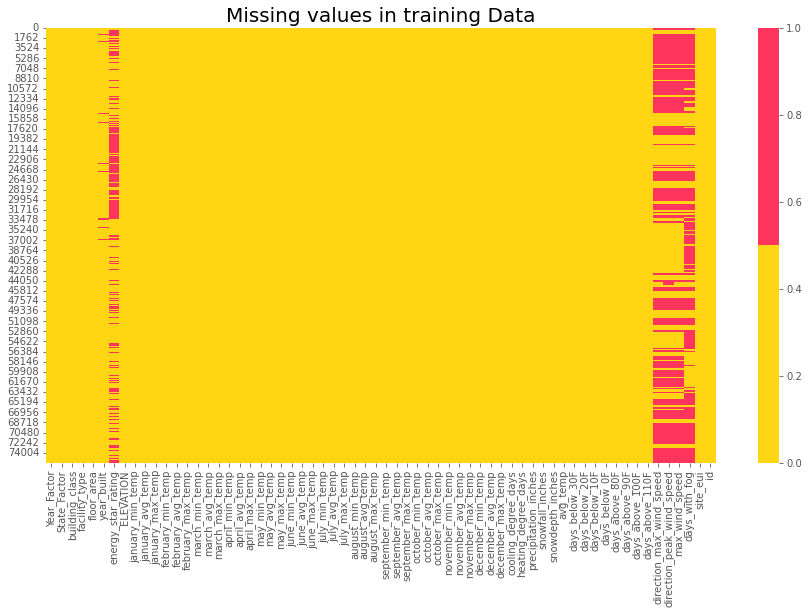

In [7]:
plt.figure(figsize = (15,8))
sns.heatmap(train.isna().values, cmap = ['#ffd514','#ff355d'], xticklabels=train.columns)
plt.title("Missing values in training Data", size=20);

In [8]:
def display_missing_data(df):
    missing_data = df.isnull().sum().reset_index()
    missing_data = missing_data.rename({'index': 'Column', 0: 'Null'}, axis=1)
    missing_data['Null_Percenatage'] = missing_data['Null'] / len(df)
    missing_data = missing_data.loc[missing_data['Null'] > 0]
    return missing_data

In [9]:
display_missing_data(train)

,Column,Null,Null_Percenatage
5,year_built,1837,0.024249
6,energy_star_rating,26709,0.352561
58,direction_max_wind_speed,41082,0.542287
59,direction_peak_wind_speed,41811,0.551909
60,max_wind_speed,41082,0.542287
61,days_with_fog,45796,0.604512


In [10]:
display_missing_data(test)

,Column,Null,Null_Percenatage
5,year_built,92,0.009480
6,energy_star_rating,2254,0.232251
58,direction_max_wind_speed,8575,0.883565
59,direction_peak_wind_speed,8575,0.883565
60,max_wind_speed,8575,0.883565
61,days_with_fog,9117,0.939413


### 3. Variable Distribution

In [11]:
# basic stats of features
train.describe().style.background_gradient()

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
count,75757.000000,75757.000000,73920.000000,49048.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,34675.000000,33946.000000,34675.000000,29961.000000,75757.000000,75757.000000
mean,4.367755,165983.865858,1952.306764,61.048605,39.506323,11.432343,34.310468,59.054952,11.720567,35.526837,58.486278,21.606281,44.469292,70.897831,32.037171,53.784863,82.661932,44.706179,63.742547,88.987856,51.131763,71.066384,91.400280,60.571604,76.596879,95.543950,58.515068,75.348749,92.572581,50.791689,69.597545,92.171139,38.210911,58.727038,81.135671,28.630397,48.123133,71.202397,22.736777,41.625569,64.496852,1202.250446,4324.957390,42.430651,29.136379,164.862455,56.176705,48.756511,17.447932,4.886532,0.876764,82.709809,14.058701,0.279539,0.002442,66.552675,62.779974,4.190601,109.142051,82.584693,37878.000000
std,1.471441,246875.790940,37.053619,28.663683,60.656596,9.381027,6.996108,5.355458,12.577272,8.866697,8.414611,10.004303,6.657142,7.680982,5.577279,2.500473,4.101028,4.200319,2.792919,2.864669,3.415926,2.861681,3.604068,4.177109,4.090275,4.157118,4.441992,3.818895,4.139685,4.290884,3.603773,5.011708,5.093899,2.641300,5.579513,7.153244,4.094207,4.373374,9.014047,5.869386,6.054104,391.561780,824.366727,10.592205,17.810894,175.275869,2.241940,27.587124,14.469435,7.071221,2.894244,25.282913,10.943996,2.252323,0.142140,131.147834,130.308106,6.458789,50.699751,58.255403,21869.306509
min,1.000000,943.000000,0.000000,0.000000,-6.400000,-19.000000,10.806452,42.000000,-13.000000,13.250000,38.000000,-9.000000,25.854839,53.000000,15.000000,40.280000,62.000000,23.000000,46.950000,64.000000,30.000000,54.100000,67.000000,37.000000,54.822581,65.000000,31.000000,56.693548,66.000000,26.000000,53.600000,64.000000,18.000000,44.693548,59.000000,4.000000,30.766667,53.000000,-16.000000,23.790323,42.000000,0.000000,398.000000,0.000000,0.000000,0.000000,44.512329,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,12.000000,1.001169,0.000000
25%,3.000000,62379.000000,1927.000000,40.000000,11.900000,6.000000,29.827586,56.000000,2.000000,31.625000,55.000000,13.000000,38.096774,62.000000,26.000000,52.333333,80.000000,42.000000,62.790323,88.000000,50.000000,70.983333,89.000000,57.000000,76.145161,95.000000,57.000000,74.516129,90.000000,47.000000,68.200000,91.000000,35.000000,58.048387,78.000000,23.000000,45.250000,69.000000,17.000000,38.532258,60.000000,1128.000000,3978

In [12]:
# def kdeplot_features(df_train,df_test, feature, title):
#     '''Takes a column from the dataframe and plots the distribution (after count).'''
    
#     values_train = df_train[feature].to_numpy()
#     values_test = df_test[feature].to_numpy()  
     
#     plt.figure(figsize = (18, 3))
    
#     sns.kdeplot(values_train, color = '#ffd514')
#     sns.kdeplot(values_test, color = '#ff355d')
    
#     plt.title(title, fontsize=15)
#     plt.legend()
#     plt.show();
    
#     del values_train , values_test
#     gc.collect()

In [13]:
# plot distributions of features
# numerical_features = train.select_dtypes('number').columns
# for feature in numerical_features:
#     if feature != "site_eui":
#         kdeplot_features(train,test, feature=feature, title = feature + " distribution")

In [14]:
# def countplot_features(df_train, feature, title):
#     '''Takes a column from the dataframe and plots the distribution (after count).'''
    
           
#     plt.figure(figsize = (10, 5))
    
#     sns.countplot(df_train[feature], color = '#ff355d')
        
#     plt.title(title, fontsize=15)    
#     plt.show();

In [15]:
# # plot distributions of categorical features
# categorical_features = ['State_Factor', 'building_class', 'facility_type']
# for feature in categorical_features:
#     fig = countplot_features(train, feature=feature, title = "Frequency of "+ feature)

In [16]:
# corr = train.corr()
# fig, ax = plt.subplots()
# fig.set_size_inches(20, 15)
# sns.heatmap(corr, vmin=0, vmax=1, linewidths=2, square=True, cmap='Blues')

### 4. Splitting Dataset

In [17]:
from sklearn.model_selection import train_test_split

### 5. Label Encoding for Categorical Data

In [18]:
# Create an Instance of LabelEncoder
le = LabelEncoder()

train['building_class']= le.fit_transform(train['building_class']).astype("uint8")
train['facility_type']= le.fit_transform(train['facility_type']).astype("uint8")

In [19]:
# Create an Instance of LabelEncoder
le = LabelEncoder()

# test['State_Factor']= le.fit_transform(test['State_Factor']).astype("uint8")

test['building_class']= le.fit_transform(test['building_class']).astype("uint8")
test['facility_type']= le.fit_transform(test['facility_type']).astype("uint8")

### 6. Handle Missing Data - Missing Values Imputation

#### 6.1 Simple Imputation for Year and Energy Star Rating

In [20]:
# year_built: replace with current year.
train['year_built'] = train['year_built'].replace(np.nan, 2022)
train['year_built'].isna().sum()

0

In [21]:
#replacing the Null values of Energy Star Rating with mean
train['energy_star_rating'] = train['energy_star_rating'].replace(np.nan,train['energy_star_rating'].mean())

In [22]:
test['year_built'] = test['year_built'].replace(np.nan, 2022)
test['energy_star_rating'] = test['energy_star_rating'].replace(np.nan,test['energy_star_rating'].mean())

#### 6.2 Missing Data Imputation

In [23]:
train1 = train.copy().drop(["Year_Factor","State_Factor"], axis=1)
train1["Year_State"]=train["Year_Factor"].astype(str) + "-" + train["State_Factor"]

In [24]:
test1 = test.copy()
test1.drop(["Year_Factor","State_Factor", "id"], axis=1)
test1["Year_State"]=test1["Year_Factor"].astype(str) + "-" + test1["State_Factor"]

In [25]:
test1['Year_State']= le.fit_transform(test1['Year_State']).astype("uint8")
test1

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,id,Year_State
0,7,State_1,0,13,28484.0,1994.0,37.0,2.4,38,50.596774,...,29,5,2,0,NaN,NaN,NaN,NaN,75757,0
1,7,State_1,0,13,21906.0,1961.0,55.0,45.7,38,50.596774,...,29,5,2,0,NaN,NaN,NaN,NaN,75758,0
2,7,State_1,0,13,16138.0,1950.0,1.0,59.1,38,50.596774,...,29,5,2,0,NaN,NaN,NaN,NaN,75759,0
3,7,State_1,0,13,97422.0,1971.0,34.0,35.4,38,50.596774,...,29,5,2,0,NaN,NaN,NaN,NaN,75760,0
4,7,State_1,0,13,61242.0,1942.0,35.0,1.8,38,50.596774,...,29,5,2,0,340.0,330.0,22.8,126.0,75761,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9700,7,State_11,1,1,305925.0,2013.0,99.0,812.0,21,38.661290,...,39,3,0,0,NaN,NaN,NaN,NaN,85457,2
9701,7,State_11,1,1,34909.0,1910.0,94.0,26.5,21,38.661290,...,39,3,0,0,NaN,NaN,NaN,NaN,85458,2
9702,7,State_11,1,1,42393.0,2014.0,94.0,812.0,21,38.661290,...,39,3,0,0,NaN,NaN,NaN,NaN,85459,2
9703,7,State_11,1,1,25368.0,1992.0,79.0,812.0,21,38.661290,...,39,3,0,0,NaN,NaN,NaN,NaN,85460,2


In [26]:
#Label Encoding for Year_State column, so we can do Imputation later
train1['Year_State']= le.fit_transform(train1['Year_State']).astype("uint8")
train1

,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,...,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id,Year_State
0,0,13,61242.0,1942.0,11.000000,2.4,36,50.500000,68,35,...,0,0,0,1.0,1.0,1.0,NaN,248.682615,0,0
1,0,55,274000.0,1955.0,45.000000,1.8,36,50.500000,68,35,...,0,0,0,1.0,NaN,1.0,12.0,26.500150,1,0
2,0,48,280025.0,1951.0,97.000000,1.8,36,50.500000,68,35,...,0,0,0,1.0,NaN,1.0,12.0,24.693619,2,0
3,0,6,55325.0,1980.0,46.000000,1.8,36,50.500000,68,35,...,0,0,0,1.0,NaN,1.0,12.0,48.406926,3,0
4,0,56,66000.0,1985.0,100.000000,2.4,36,50.500000,68,35,...,0,0,0,1.0,1.0,1.0,NaN,3.899395,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75752,0,32,20410.0,1995.0,8.000000,36.6,28,43.451613,56,34,...,3,0,0,NaN,NaN,NaN,NaN,132.918411,75752,26
75753,1,1,40489.0,1910.0,98.000000,36.6,28,43.451613,56,34,...,3,0,0,NaN,NaN,NaN,NaN,39.483672,75753,26
75754,0,2,28072.0,1917.0,61.048605,36.6,26,36.612903,48,30,...,0,0,0,NaN,NaN,NaN,NaN,48.404398,75754,26
75755,0,2,53575.0,2012.0,61.048605,36.6,26,36.612903,48,30,...,0,0,0,NaN,NaN,NaN,NaN,592.022750,75755,26


In [27]:
display_missing_data(train1)

,Column,Null,Null_Percenatage
56,direction_max_wind_speed,41082,0.542287
57,direction_peak_wind_speed,41811,0.551909
58,max_wind_speed,41082,0.542287
59,days_with_fog,45796,0.604512


In [28]:
display_missing_data(test)

,Column,Null,Null_Percenatage
58,direction_max_wind_speed,8575,0.883565
59,direction_peak_wind_speed,8575,0.883565
60,max_wind_speed,8575,0.883565
61,days_with_fog,9117,0.939413


In [29]:
# Imputation for the Missing values of direction_max_wind_speed with groupby Year_State mean 
temp_columns = "direction_max_wind_speed Year_State".split()
temp_df = train1.groupby(["Year_State"]).agg("mean").direction_max_wind_speed
pre_df = train1.direction_max_wind_speed.copy()
train1.direction_max_wind_speed = train1[temp_columns].apply(lambda x:temp_df[x[1]] if pd.isnull(x[0]) else x[0],axis=1)
pd.DataFrame({"old":pre_df.values,"new":train1.direction_max_wind_speed.values}).transpose()

# Fill in the rest of Missing values with Mean 
train1.direction_max_wind_speed.fillna(int(train1.direction_max_wind_speed.mean()), inplace=True)
train1.direction_max_wind_speed.astype(int)

0        1
1        1
2        1
3        1
4        1
        ..
75752    1
75753    1
75754    1
75755    1
75756    1
Name: direction_max_wind_speed, Length: 75757, dtype: int64

In [30]:
# Imputation for the Missing values of direction_max_wind_speed with groupby Year_State mean 
temp_columns = "direction_max_wind_speed Year_State".split()
temp_df = test1.groupby(["Year_State"]).agg("mean").direction_max_wind_speed
pre_df = test1.direction_max_wind_speed.copy()
test1.direction_max_wind_speed = test1[temp_columns].apply(lambda x:temp_df[x[1]] if pd.isnull(x[0]) else x[0],axis=1)
pd.DataFrame({"old":pre_df.values,"new":test1.direction_max_wind_speed.values}).transpose()

# Fill in the rest of Missing values with Mean 
test1.direction_max_wind_speed.fillna(int(test1.direction_max_wind_speed.mean()), inplace=True)
test1.direction_max_wind_speed.astype(int)

0       340
1       340
2       340
3       340
4       340
       ... 
9700    297
9701    297
9702    297
9703    297
9704    297
Name: direction_max_wind_speed, Length: 9705, dtype: int64

In [31]:
# Imputation for the Missing values of direction_peak_wind_speed with groupby Year_State mean 
temp_columns = "direction_peak_wind_speed Year_State".split()
temp_df = train1.groupby(["Year_State"]).agg("mean").direction_peak_wind_speed
pre_df = train1.direction_peak_wind_speed.copy()
train1.direction_peak_wind_speed = train1[temp_columns].apply(lambda x:temp_df[x[1]] if pd.isnull(x[0]) else x[0],axis=1)
pd.DataFrame({"old":pre_df.values,"new":train1.direction_peak_wind_speed.values}).transpose()

# Fill in the rest of Missing values with Mean 
train1.direction_peak_wind_speed.fillna(int(train1.direction_peak_wind_speed.mean()), inplace=True)
train1.direction_peak_wind_speed.astype(int)

0        1
1        1
2        1
3        1
4        1
        ..
75752    1
75753    1
75754    1
75755    1
75756    1
Name: direction_peak_wind_speed, Length: 75757, dtype: int64

In [32]:
# Imputation for the Missing values of direction_peak_wind_speed with groupby Year_State mean 
temp_columns = "direction_peak_wind_speed Year_State".split()
temp_df = test1.groupby(["Year_State"]).agg("mean").direction_peak_wind_speed
pre_df = test1.direction_peak_wind_speed.copy()
test1.direction_peak_wind_speed = test1[temp_columns].apply(lambda x:temp_df[x[1]] if pd.isnull(x[0]) else x[0],axis=1)
pd.DataFrame({"old":pre_df.values,"new":test1.direction_peak_wind_speed.values}).transpose()

# Fill in the rest of Missing values with Mean 
test1.direction_peak_wind_speed.fillna(int(test.direction_peak_wind_speed.mean()), inplace=True)
test1.direction_peak_wind_speed.astype(int)

0       330
1       330
2       330
3       330
4       330
       ... 
9700    252
9701    252
9702    252
9703    252
9704    252
Name: direction_peak_wind_speed, Length: 9705, dtype: int64

In [33]:
# Imputation for the Missing values of max_wind_speed with groupby Year_State mean 
temp_columns = "max_wind_speed Year_State".split()
temp_df = train1.groupby(["Year_State"]).agg("mean").max_wind_speed
pre_df = train1.max_wind_speed.copy()
train1.max_wind_speed = train1[temp_columns].apply(lambda x:temp_df[x[1]] if pd.isnull(x[0]) else x[0],axis=1)
pd.DataFrame({"old":pre_df.values,"new":train1.max_wind_speed.values}).transpose()

# Fill in the rest of Missing values with Mean 
train1.max_wind_speed.fillna(int(train1.max_wind_speed.mean()), inplace=True)
train1.max_wind_speed.astype(int)

0        1
1        1
2        1
3        1
4        1
        ..
75752    1
75753    1
75754    1
75755    1
75756    1
Name: max_wind_speed, Length: 75757, dtype: int64

In [34]:
# Imputation for the Missing values of max_wind_speed with groupby Year_State mean 
temp_columns = "max_wind_speed Year_State".split()
temp_df = test1.groupby(["Year_State"]).agg("mean").max_wind_speed
pre_df = test1.max_wind_speed.copy()
test1.max_wind_speed = test1[temp_columns].apply(lambda x:temp_df[x[1]] if pd.isnull(x[0]) else x[0],axis=1)
pd.DataFrame({"old":pre_df.values,"new":test1.max_wind_speed.values}).transpose()

# Fill in the rest of Missing values with Mean 
test1.max_wind_speed.fillna(int(test.max_wind_speed.mean()), inplace=True)
test1.max_wind_speed.astype(int)

0       22
1       22
2       22
3       22
4       22
        ..
9700    15
9701    15
9702    15
9703    15
9704    15
Name: max_wind_speed, Length: 9705, dtype: int64

In [35]:
# Imputation for the Missing values of days_with_fog with groupby Year_State mean 
temp_columns = "days_with_fog Year_State".split()
temp_df = train1.groupby(["Year_State"]).agg("mean").days_with_fog
pre_df = train1.days_with_fog.copy()
train1.days_with_fog = train1[temp_columns].apply(lambda x:temp_df[x[1]] if pd.isnull(x[0]) else x[0],axis=1)
pd.DataFrame({"old":pre_df.values,"new":train1.days_with_fog.values}).transpose()

# Fill in the rest of Missing values with Mean 
train1.days_with_fog.fillna(int(train1.days_with_fog.mean()), inplace=True)
train1.days_with_fog.astype(int)

0         12
1         12
2         12
3         12
4         12
        ... 
75752    261
75753    261
75754    261
75755    261
75756    261
Name: days_with_fog, Length: 75757, dtype: int64

In [36]:
# Imputation for the Missing values of days_with_fog with groupby Year_State mean 
temp_columns = "days_with_fog Year_State".split()
temp_df = test1.groupby(["Year_State"]).agg("mean").days_with_fog
pre_df = test1.days_with_fog.copy()
test1.days_with_fog = test1[temp_columns].apply(lambda x:temp_df[x[1]] if pd.isnull(x[0]) else x[0],axis=1)
pd.DataFrame({"old":pre_df.values,"new":test1.days_with_fog.values}).transpose()

# Fill in the rest of Missing values with Mean 
test1.days_with_fog.fillna(int(test.days_with_fog.mean()), inplace=True)
test1.days_with_fog.astype(int)

0       126
1       126
2       126
3       126
4       126
       ... 
9700    250
9701    250
9702    250
9703    250
9704    250
Name: days_with_fog, Length: 9705, dtype: int64

In [37]:
train1.isna().sum().sum()

0

In [38]:
test1.isna().sum().sum()

0

In [39]:
# Convert back the imputed data into X_train dataframe
train["direction_max_wind_speed"] = train1["direction_max_wind_speed"]
train["direction_peak_wind_speed"] = train1["direction_peak_wind_speed"]
train["max_wind_speed"] = train1["max_wind_speed"]
train["days_with_fog"] = train1["days_with_fog"]

train.isna().sum().sum()

0

In [40]:
# Convert back the imputed data into X_val dataframe
test["direction_max_wind_speed"] = test1["direction_max_wind_speed"]
test["direction_peak_wind_speed"] = test1["direction_peak_wind_speed"]
test["max_wind_speed"] = test1["max_wind_speed"]
test["days_with_fog"] = test1["days_with_fog"]

test.isna().sum().sum()

0

In [41]:
train

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,0,13,61242.0,1942.0,11.000000,2.4,36,50.500000,...,14,0,0,0,1.0,1.0,1.0,12.0,248.682615,0
1,1,State_1,0,55,274000.0,1955.0,45.000000,1.8,36,50.500000,...,14,0,0,0,1.0,1.0,1.0,12.0,26.500150,1
2,1,State_1,0,48,280025.0,1951.0,97.000000,1.8,36,50.500000,...,14,0,0,0,1.0,1.0,1.0,12.0,24.693619,2
3,1,State_1,0,6,55325.0,1980.0,46.000000,1.8,36,50.500000,...,14,0,0,0,1.0,1.0,1.0,12.0,48.406926,3
4,1,State_1,0,56,66000.0,1985.0,100.000000,2.4,36,50.500000,...,14,0,0,0,1.0,1.0,1.0,12.0,3.899395,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75752,6,State_11,0,32,20410.0,1995.0,8.000000,36.6,28,43.451613,...,25,3,0,0,1.0,1.0,1.0,261.0,132.918411,75752
75753,6,State_11,1,1,40489.0,1910.0,98.000000,36.6,28,43.451613,...,25,3,0,0,1.0,1.0,1.0,261.0,39.483672,75753
75754,6,State_11,0,2,28072.0,1917.0,61.048605,36.6,26,36.612903,...,6,0,0,0,1.0,1.0,1.0,261.0,48.404398,75754
75755,6,State_11,0,2,53575.0,2012.0,61.048605,36.6,26,36.612903,...,6,0,0,0,1.0,1.0,1.0,261.0,592.022750,75755


In [42]:
test

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,id
0,7,State_1,0,13,28484.0,1994.0,37.0,2.4,38,50.596774,...,0,29,5,2,0,340.000000,330.000000,22.800000,126.0,75757
1,7,State_1,0,13,21906.0,1961.0,55.0,45.7,38,50.596774,...,0,29,5,2,0,340.000000,330.000000,22.800000,126.0,75758
2,7,State_1,0,13,16138.0,1950.0,1.0,59.1,38,50.596774,...,0,29,5,2,0,340.000000,330.000000,22.800000,126.0,75759
3,7,State_1,0,13,97422.0,1971.0,34.0,35.4,38,50.596774,...,0,29,5,2,0,340.000000,330.000000,22.800000,126.0,75760
4,7,State_1,0,13,61242.0,1942.0,35.0,1.8,38,50.596774,...,0,29,5,2,0,340.000000,330.000000,22.800000,126.0,75761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9700,7,State_11,1,1,305925.0,2013.0,99.0,812.0,21,38.661290,...,0,39,3,0,0,297.832817,252.167183,15.489474,250.0,85457
9701,7,State_11,1,1,34909.0,1910.0,94.0,26.5,21,38.661290,...,0,39,3,0,0,297.832817,252.167183,15.489474,250.0,85458
9702,7,State_11,1,1,42393.0,2014.0,94.0,812.0,21,38.661290,...,0,39,3,0,0,297.832817,252.167183,15.489474,250.0,85459
9703,7,State_11,1,1,25368.0,1992.0,79.0,812.0,21,38.661290,...,0,39,3,0,0,297.832817,252.167183,15.489474,250.0,85460


In [43]:
le = LabelEncoder()
train['State_Factor']= le.fit_transform(train['State_Factor']).astype("uint8")
test['State_Factor']= le.fit_transform(test['State_Factor']).astype("uint8")

#### 6.3 Data Standardization

In [44]:
# from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [45]:
def standardization(df):    
    std_scaler = StandardScaler()
    df = std_scaler.fit_transform(df)
    df = pd.DataFrame(df)
    return df

### 7. Building Models

In [46]:
#for modelling
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

#for evaluating model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import math

### 7.1 Splitting Dataset

In [47]:
from sklearn.model_selection import train_test_split

X = train.drop(['site_eui', 'id'], axis=1)
y = train['site_eui']   

# Splitting dataset into Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

In [48]:
# Let's see the shape of the training and test sets
print('Shape of Training set: ', X_train.shape)
print('Shape of Test set:', X_test.shape)

Shape of Training set:  (53029, 62)
Shape of Test set: (22728, 62)


In [49]:
print("{0:0.2f}% data is in training set".format((len(X_train)/len(train.index)) * 100))
print("{0:0.2f}% data is in test set".format((len(X_test)/len(train.index)) * 100))

70.00% data is in training set
30.00% data is in test set


### 7.2 Evaluate Models

In [50]:
#for modelling
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

#for evaluating model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import math

### Gradient Boosting

In [51]:
gb = RandomForestRegressor()
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)

In [52]:
test_mse=mean_squared_error(y_test,gb_pred)
print('RMSE for Gradient Boosting:',math.sqrt(test_mse))

RMSE for Gradient Boosting: 42.53052951610231


### Linear Regression

In [53]:
model = LinearRegression()
model.fit(X_train, y_train)
lr_pred = model.predict(X_test)

In [54]:
test_mse=mean_squared_error(y_test,lr_pred)
print('RMSE for Linear Regression:',math.sqrt(test_mse))

RMSE for Linear Regression: 52.93258952253992


### Decision Tree

In [55]:
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)

In [56]:
test_mse=mean_squared_error(y_test,dt_pred)
print('RMSE for Decision Tree:',math.sqrt(test_mse) )

RMSE for Decision Tree: 57.003673350816044


### Random Forest

In [57]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

In [58]:
test_mse=mean_squared_error(y_test,rf_pred)
print('RMSE for Random Forrest:',math.sqrt(test_mse) )

RMSE for Random Forrest: 42.68303213393346


##### Gradient Boosting has the lowest RMSE. Then, we move forward with it. We will now use the entire Train dataset to train the model.

In [59]:
test1 = test.drop(['id'], axis=1)
test1.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog
0,7,0,0,13,28484.0,1994.0,37.0,2.4,38,50.596774,...,0,0,29,5,2,0,340.0,330.0,22.8,126.0
1,7,0,0,13,21906.0,1961.0,55.0,45.7,38,50.596774,...,0,0,29,5,2,0,340.0,330.0,22.8,126.0
2,7,0,0,13,16138.0,1950.0,1.0,59.1,38,50.596774,...,0,0,29,5,2,0,340.0,330.0,22.8,126.0
3,7,0,0,13,97422.0,1971.0,34.0,35.4,38,50.596774,...,0,0,29,5,2,0,340.0,330.0,22.8,126.0
4,7,0,0,13,61242.0,1942.0,35.0,1.8,38,50.596774,...,0,0,29,5,2,0,340.0,330.0,22.8,126.0


In [60]:
GB = RandomForestRegressor()
GB.fit(X, y)
Prediction = GB.predict(test1)

In [61]:
output = pd.DataFrame({'id': test.id, 'Prediction': Prediction})
output.to_csv('submission.csv', index=False)